In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

all_df = trainid_df.join(properties_df)

In [48]:
# Only use the necessary data.

all_df = all_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
all_df = all_df.dropna()

npoints = len(all_df.logerror.values)
origerror = np.mean(np.abs(all_df.logerror.values))

In [97]:
# Make function for binning values in an array

def makebins(X, nbins = 50):
    X2 = X.copy()
    maxval = np.amax(X2)
    minval = np.amin(X2)
    X2 = (X2 - minval) / (maxval - minval) * nbins
    X2 = X2.astype(int)
    X2 = minval + X2 * (maxval - minval) / nbins
    return X2

# Make function for bin fit. Assume data in X is already in bins ( so we don't bin year built in the same way).

def binfit(X, y, nbins = 10):
    nrows, nXcols = X.shape
    alldata = np.hstack((X, y))
    Xnames = ['X' + str(i) for i in range(nXcols)]
    colnames = Xnames + ['y']
    new_df = pd.DataFrame(alldata, columns = colnames)
    grouped_df = new_df.groupby(Xnames).median()
    predictdict = {t : py for t, py in zip(grouped_df.index.values, grouped_df.y.values)}
    return predictdict

def bintransform(X, y, valdict):
    nrows, nXcols = X.shape
    ypredict = []
    for row in X:
        
        key = tuple(row)
        
        # If key isn't present for some reason, then just assume
        # the zillow model is correct.
        
        if key in valdict:
            ypredict.append(valdict[key])
        else:
            ypredict.append(0.0)
    
    return np.array(ypredict).reshape(-1,1)

In [98]:
# Let's get a benchmark for how well a simple piecewise constant function will perform.

tobin = ['latitude', 'longitude']
bins = np.zeros((npoints, len(tobin)))

for i in range(len(tobin)):
    bins[:, i] = makebins(all_df[tobin[i]].values, nbins = 6)
    all_df['bin' + str(i)] = bins[:, i]
    
X = np.hstack((bins, all_df.yearbuilt.values.reshape(-1,1)))
    
y = all_df.logerror.values.reshape(-1,1)

predictdict = binfit(X, y)
ypredict = bintransform(X, y, predictdict)

yerror = np.abs(ypredict - y)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

0.0661815424658
-0.0252870847278


In [99]:
# Now let's check with validation.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.1, random_state = 50)

predictdict = binfit(X_train, y_train)

# First check results on training data
print('For training data')

ypredict = bintransform(X_train, y_train, predictdict)
yerror = np.abs(ypredict - y_train)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

# Now validate on testing data.

print('For test data')
ypredict = bintransform(X_test, y_test, predictdict)

yerror = np.abs(ypredict - y_test)
yerror = np.mean(yerror)
print(yerror)

relerror = (yerror - origerror) / origerror
print(relerror)

For training data
0.0662064232254
-0.0249206442254
For test data
0.0674688896336
-0.00632720763668


In [113]:
# Let's see how training error and testing error depends on the number of bins.

tobin = ['latitude', 'longitude']
bins = np.zeros((npoints, len(tobin)))
setofnbins = range(1,100, 5)

errors = {'train' : [], 'test' : []}

for nbins in setofnbins:
    
    for i in range(len(tobin)):
        bins[:, i] = makebins(all_df[tobin[i]].values, nbins = nbins)
    
    X = np.hstack((bins, all_df.yearbuilt.values.reshape(-1,1)))
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.25, random_state = 50)

    predictdict = binfit(X_train, y_train)
    
    # Get training error.
    
    ypredict = bintransform(X_train, y_train, predictdict)
    yerror = np.abs(ypredict - y_train)
    yerror = np.mean(yerror)
    errors['train'].append(yerror)
    
    # Get test error.
    
    ypredict = bintransform(X_test, y_test, predictdict)
    yerror = np.abs(ypredict - y_test)
    yerror = np.mean(yerror)
    errors['test'].append(yerror)
        
errors = {key : np.array(errors[key]) for key in errors}
relerrors = {key : (errors[key] - origerror) /  origerror for key in errors}

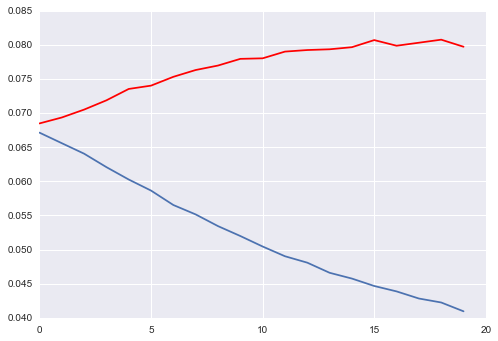

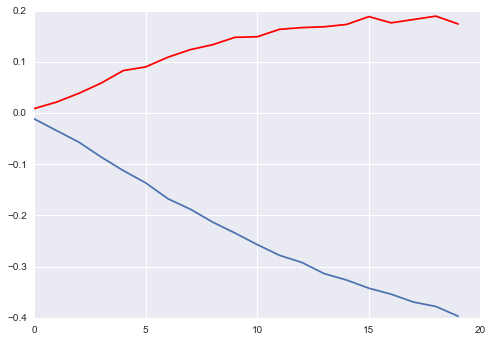

In [114]:
# Plot results of training and test error depending on the number of bins.

plt.plot(errors['test'], color = 'red')
plt.plot(errors['train'])
plt.show()

plt.plot(relerrors['test'], color = 'red')
plt.plot(relerrors['train'])
plt.show()